In [1]:
%matplotlib inline
import math
from math import pi

import numpy as np
import pandas as pd
import collections

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score 
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.stats import mode
from scipy.spatial.distance import pdist


In [2]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, sep=',',index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 3885
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2072 non-null   object 
 1   ratio                  2072 non-null   float64
 2   num_matches_2016-2019  2072 non-null   float64
 3   ratio_2016-2019        2072 non-null   float64
 4   num_matches_2020-2021  2072 non-null   float64
 5   ratio_2020-2021        2072 non-null   float64
 6   hand                   2072 non-null   object 
 7   gender                 2072 non-null   object 
 8   ioc                    2072 non-null   object 
 9   birth                  2072 non-null   float64
 10  ht                     2072 non-null   float64
 11  minutes                2072 non-null   float64
 12  perc_ace               2072 non-null   float64
 13  serv_won_tot_seve      2072 non-null   float64
 14  bpFaced                2072 non-null   float64
 15  perc

## drop categorical data

In [3]:
del df['name']
del df['hand']
del df['gender']
del df['ioc']

In [4]:
df.head()

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
0,0.181818,10.0,0.200000,1.0,0.000000,1996.0,187.076923,86.694444,14.98,0.587855,83.0,12.32,47.78,8.82,5.88,75.79
1,0.477707,142.0,0.478873,15.0,0.466667,1994.0,170.857143,61.621951,1.30,0.279256,819.0,4.67,22.10,3.18,5.39,39.67
2,0.500000,13.0,0.461538,3.0,0.666667,1998.0,183.800000,86.875000,20.59,0.613701,111.0,10.89,51.65,7.12,10.10,70.86
4,0.588710,111.0,0.576577,13.0,0.692308,1992.0,172.137193,62.577626,3.37,0.591260,1055.0,11.18,54.40,3.83,7.73,52.62
5,0.153846,13.0,0.153846,0.0,0.000000,1995.0,172.137193,59.409091,0.00,0.189542,110.0,16.30,17.20,0.51,2.55,11.88


## drop most correlated attributes

In [5]:
corr_threshold = 0.9
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df.columns)):
    for j in range(i+1, len(df.columns)):
        corr = df[df.columns[i]].corr(df[df.columns[j]])
        if  corr > corr_threshold:
            print(df.columns[i] + "\t" + df.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
num_matches_2016-2019	bpFaced	0.9253
serv_won_tot_seve	perc_2ndwon	0.9248


In [6]:
del df['bpFaced']
del df['perc_2ndwon']
del df['serv_won_tot_seve']
del df['num_matches_2016-2019']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ratio                  2072 non-null   float64
 1   ratio_2016-2019        2072 non-null   float64
 2   num_matches_2020-2021  2072 non-null   float64
 3   ratio_2020-2021        2072 non-null   float64
 4   birth                  2072 non-null   float64
 5   ht                     2072 non-null   float64
 6   minutes                2072 non-null   float64
 7   perc_ace               2072 non-null   float64
 8   perc_df                2072 non-null   float64
 9   perc_v_ace             2072 non-null   float64
 10  perc_v_df              2072 non-null   float64
 11  perc_v_1stwon          2072 non-null   float64
dtypes: float64(12)
memory usage: 210.4 KB


## Normalization by Min-max

A good practice in clustering to avoid the bias given by the range of the different attribute is normalization.
The most common adopted normalizations are: Z-Score and Min-Max

### Min-Max

In [8]:
minmax = MinMaxScaler()
df_norm_minmax = minmax.fit_transform(df.values)
print(df_norm_minmax)

[[0.06811316 0.2        0.00990099 ... 0.37650602 0.32867524 0.93740611]
 [0.48378779 0.47887324 0.14851485 ... 0.133821   0.30128563 0.48522784]
 [0.51510574 0.46153846 0.02970297 ... 0.30335628 0.56456121 0.87568853]
 ...
 [0.44116712 0.38596491 0.18811881 ... 0.07917384 0.22079374 0.34088633]
 [0.57580844 0.53846154 0.02970297 ... 0.36660929 0.41475685 0.82511267]
 [0.54257456 0.54658385 0.17821782 ... 0.09380379 0.28731135 0.44416625]]


### Z-Score Normalization

In [9]:
zscore = StandardScaler()
zscore.fit(df.values)

StandardScaler()

In [10]:
df_norm_zscore=zscore.transform(df.values)

## Hierarchical clustering 

#### There are 2 kinds of hierarchical clustering: agglomerative and divisive. In the following, there are some example of the agglomerative clustering using scipy. The scipy library allows for hierachical clusters by exploiting the linkage function and then the dendrogram. The first function, given a matrix of pair-wise distances, computes the agglomerative clustering. There are 2 parameters: the method, that can be single, complete, ward, average, weighted, centroids and median, and the metric used to compute the distances, such as euclidean or cosine. Then, with the dendrogram function, it is possible to visualize the result obtained. This kind of clustering is also possible with scikit-learn library, but the dendrogram visualization is not directly available.


selezione dei parametri, qui decido i metodi da utilizzare per i cluster e gli step che mi serviranno successivamente per determinare i migliori cluster

In [11]:
#set data for MinMax
data=df_norm_minmax
steps = [0.001, 0.01, 0.01, 0.1]

#set data for Z-Score
#data=df_norm_zscore
#steps = [0.01, 0.1, 0.1, 3]

methods = ['single', 'complete', 'average', 'ward']

In [12]:
def plot_dendrogram(model, **kwargs):

    n_sample = np.zeros(model.children_.shape[0])
    samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < samples:
                current_count += 1 
            else:
                current_count += n_sample[child_idx - samples]
        n_sample[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, n_sample]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

funzione per rappresentare i grafici dei vari metodi

In [13]:
def plot_graph(axs,i,c_thresholds):
    axs[i].set_title('Hierarchical Clustering from ' + methods[i] + ' \n Color Threshold: ' + '{:2.4f}'.format(c_thresholds))
    axs[i].set_xlabel('PlayerID or (Cluster Size)')
    axs[i].set_ylabel('Distance')
    axs[i].axhline(c_thresholds, ls='--', color='r')
    return axs


Calcolo l'altezza del taglio di default

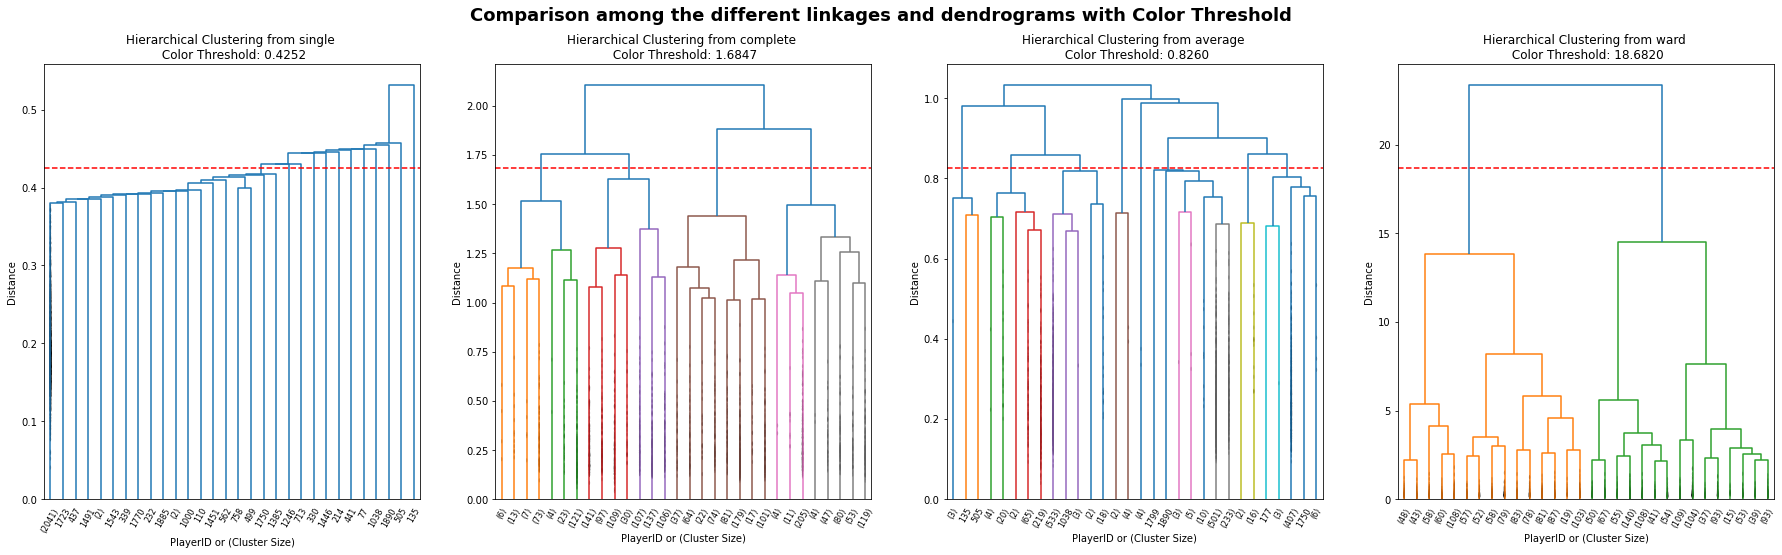

In [14]:
#for each method we go to calculate the agglomerative cluster and then print on the screen the various dendrograms associated with the respective default treshold
color_thresholds = []

f, axs = plt.subplots(ncols=4, figsize=(31,8))

for i in range(len(methods)):
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage=methods[i]).fit(data) 
    plot_dendrogram(model, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True, ax=axs[i])
    link_matrix = linkage(data, methods[i])
    #mi prendo il treshold pari a 4/5 della dimensione di ciascuna matrice di linkage (terza colonna)
    c_threshold=0.8*max(link_matrix[:,2]) 
    axs=plot_graph(axs,i,c_threshold)

plt.suptitle(('Comparison among the different linkages and dendrograms with Color Threshold'), fontsize=18, fontweight='bold')
plt.show()

## Identifying the best cut

Now to find the best number of clusters we need to find a correct threshold value, in our case we have defined ourselves as a function that iterates step by step. The method to be used, the steps through which to iterate and the normalized data takes function as input. We'll take the cluster for each methods with most occurency (maximum distance)

In [15]:
def get_best_cut(linkage, step, norm_data):
    clusters_number = []
    distances = []
    n_clusters = 0
    i = 0

    while n_clusters != 1:
        threshold = i*step
        model = AgglomerativeClustering(distance_threshold=threshold, n_clusters=None, affinity='euclidean', linkage=linkage).fit(norm_data)
        i = i + 1

        n_clusters = model.n_clusters_
        distances.append(threshold)
        clusters_number.append(n_clusters)

    df = pd.DataFrame()
    df['distance'] = distances
    df['n_clusters'] = clusters_number
    
    n_for_opt_cut = df.groupby('n_clusters').size().agg(['idxmax'])[0]
    distance = df[df.n_clusters == n_for_opt_cut].distance.min()
    
    print('Analysis for ' + linkage + ' reached n_clusters = 1 in ' + str(i) + ' steps')
   
    return n_for_opt_cut, distance

We search for the best cut within each of the four dendrograms.

In [16]:
best_clusters = []
heights = []

for i in range(len(methods)):
    n_for_opt_cut, height = get_best_cut(methods[i], steps[i], data)
    best_clusters.append(n_for_opt_cut)
    heights.append(height)
    
hierarchical_distances = pd.DataFrame()
hierarchical_distances['method'] = methods
hierarchical_distances['clusters_best_cut'] = best_clusters
hierarchical_distances['distance'] = heights
hierarchical_distances.set_index(['method'], inplace=True)

hierarchical_distances

Analysis for single reached n_clusters = 1 in 533 steps
Analysis for complete reached n_clusters = 1 in 212 steps
Analysis for average reached n_clusters = 1 in 105 steps
Analysis for ward reached n_clusters = 1 in 235 steps


,clusters_best_cut,distance
method,,
single,2,0.458
complete,2,1.890
average,5,0.910
ward,2,14.600


We plot the dendrograms again, this time highlighting the best cut identified above.

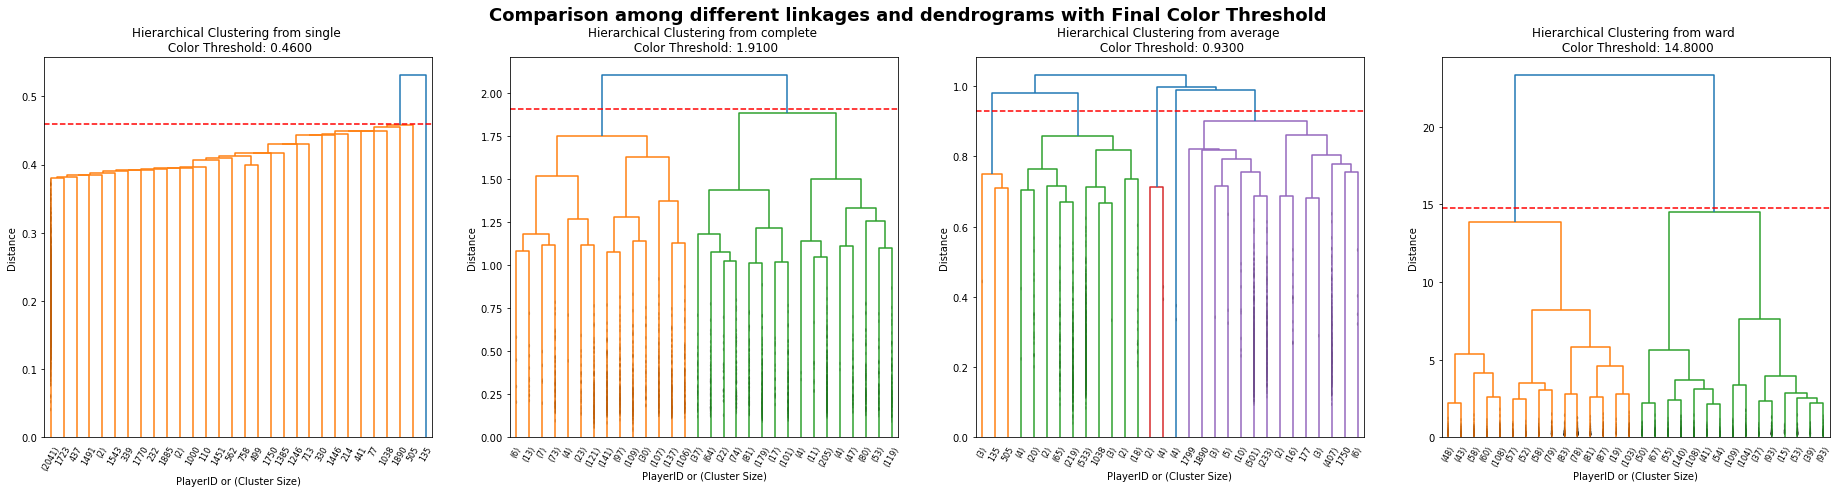

In [17]:
# plot dendrograms

f, axs = plt.subplots(ncols=4, figsize=(32,7))

for i in range(len(methods)):
    color_threshold = hierarchical_distances.loc[methods[i]].distance
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage=methods[i]).fit(data) 
    plot_dendrogram(model, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True, ax=axs[i], color_threshold=color_threshold)
  
    axs=plot_graph(axs,i,color_threshold + steps[i]*2)

plt.suptitle(('Comparison among different linkages and dendrograms with Final Color Threshold'),
             fontsize=18, fontweight='bold')
plt.show()

We compute and store the labels associated with each cut.

In [18]:
clusters_labels = pd.DataFrame()

In [19]:
for i in range(len(methods)):
    opt_n_clusters = int(hierarchical_distances.loc[methods[i]].clusters_best_cut)
    temp = AgglomerativeClustering(n_clusters=opt_n_clusters, affinity='euclidean', linkage=methods[i])
    labels=temp.fit_predict(data)
    clusters_labels[methods[i]] = labels
    print(methods[i] , labels)

clusters_labels[['single', 'complete', 'average', 'ward']]

single [0 0 0 ... 0 0 0]
complete [0 1 0 ... 1 0 1]
average [0 1 0 ... 1 0 1]
ward [0 1 0 ... 1 0 1]


,single,complete,average,ward
0,0,0,0,0
1,0,1,1,1
2,0,0,0,0
3,0,1,1,1
4,0,1,1,1
...,...,...,...,...
2067,0,1,0,1
2068,0,1,1,1
2069,0,1,1,1
2070,0,0,0,0


We compare the four clusterings by visualizing the distribution of the points among their clusters.

## Data Distribution graph with different algorithms

In [20]:
def comparison(a,b):
    f, axs = plt.subplots(nrows=1, ncols=4, figsize=(32,12))
    for i in range(len(methods)):
        labels = clusters_labels[methods[i]]
        opt_n_clusters = int(hierarchical_distances.loc[methods[i]].clusters_best_cut)
        scatter = axs[i].scatter(df[a], df[b], c=labels, s=20, cmap='cividis')
        axs[i].set_title('Scatter('+a+', '+b+') \n Method: ' + methods[i] + ', \n Number clusters: ' + str(opt_n_clusters), fontdict={'fontsize': 'large'})
        axs[i].set_xlabel(a, fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(b, fontdict={'fontsize': 'large'})

        # produce a legend with the unique colors from the scatter
        dbs_population = np.unique(labels, return_counts=True)

        legend1 = axs[i].legend(*scatter.legend_elements(), #legend_elements creates legend handles and labels for a PathCollection.
                            loc="lower center", title="Labels")

        axs[i].add_artist(legend1)

        # produce a legend 
        secondlegend = []
        classes = np.unique(labels).shape[0]

        for j in range(classes):
            secondlegend.append("{} has {} points".format(j, dbs_population[1][j]))
        handles = scatter.legend_elements()[0]
        labels_2 = secondlegend
        legend2 = axs[i].legend(handles, labels_2, loc="lower right", title="Distribution")

    plt.suptitle(('Comparison of clusterings from different algorithms'),
                 fontsize=24, fontweight='bold')

    plt.show()

### perc_v_ace-perc_v_1stwon

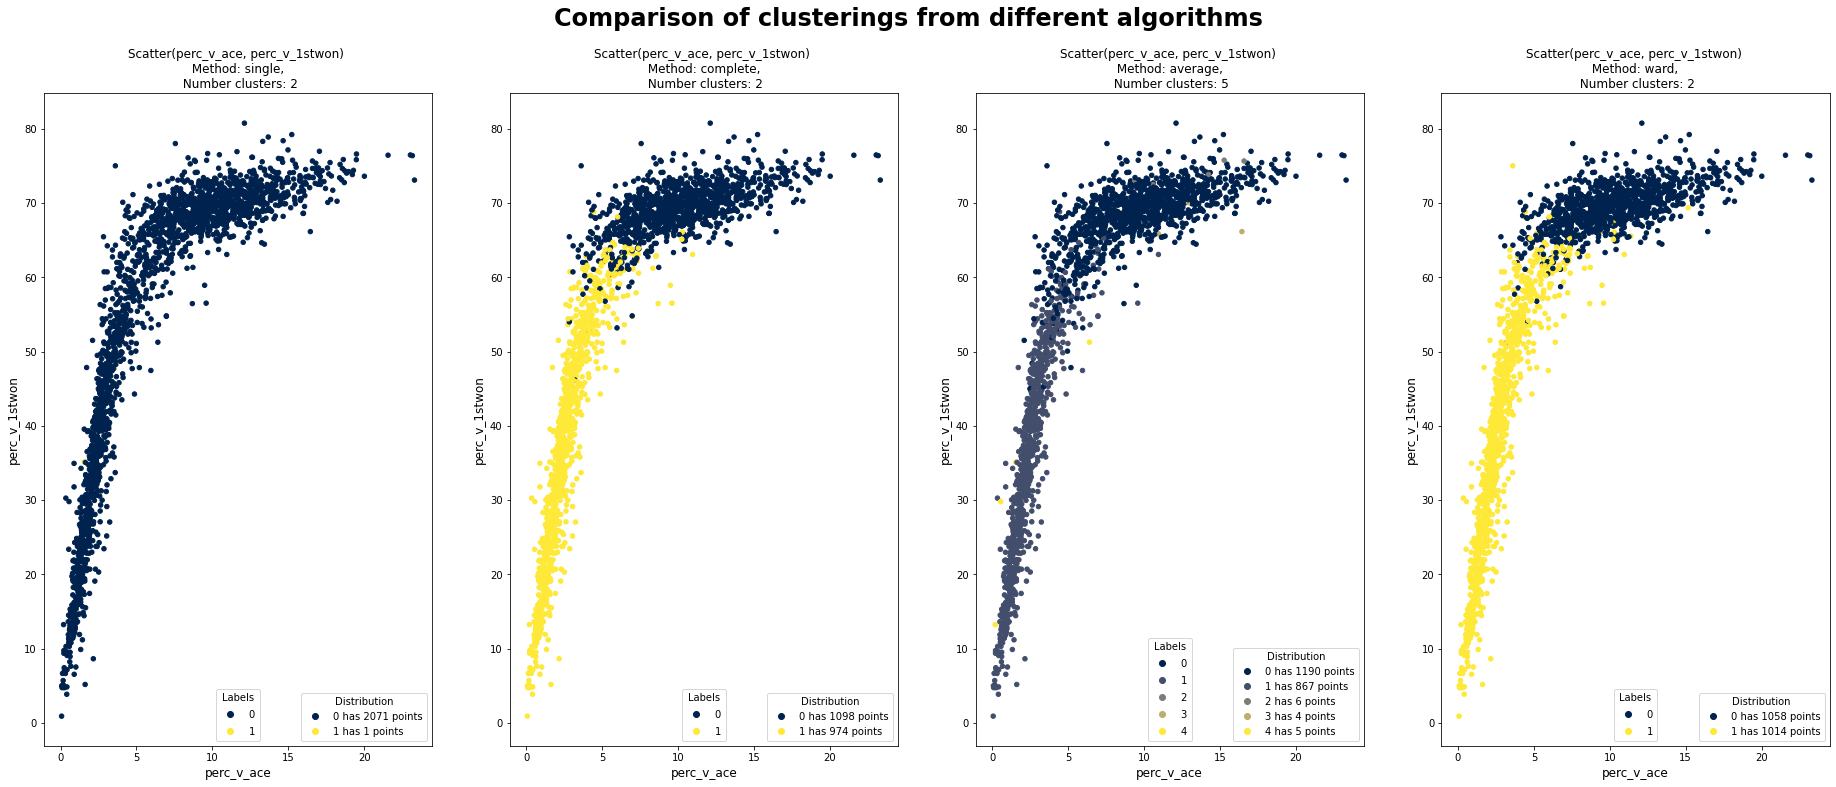

In [21]:
a, b = 'perc_v_ace', 'perc_v_1stwon'
comparison(a,b)


### perc_v_ace-perc_v_1stwon

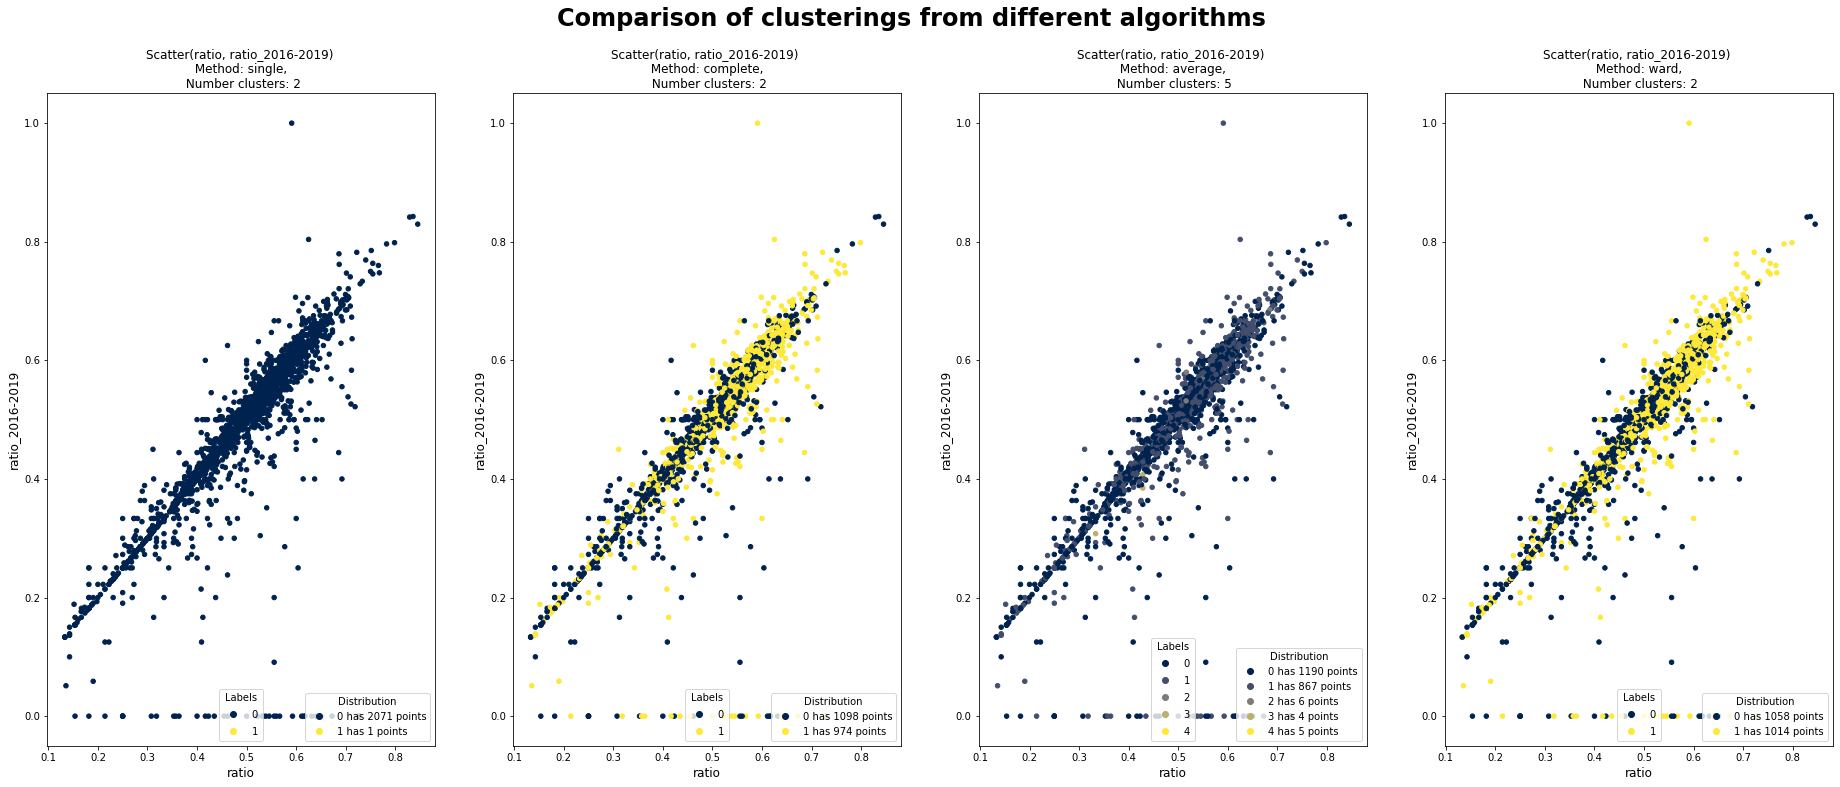

In [22]:
a, b = 'ratio', 'ratio_2016-2019'
comparison(a,b)

### num_matches_2020-2021 - ratio_2020-2021

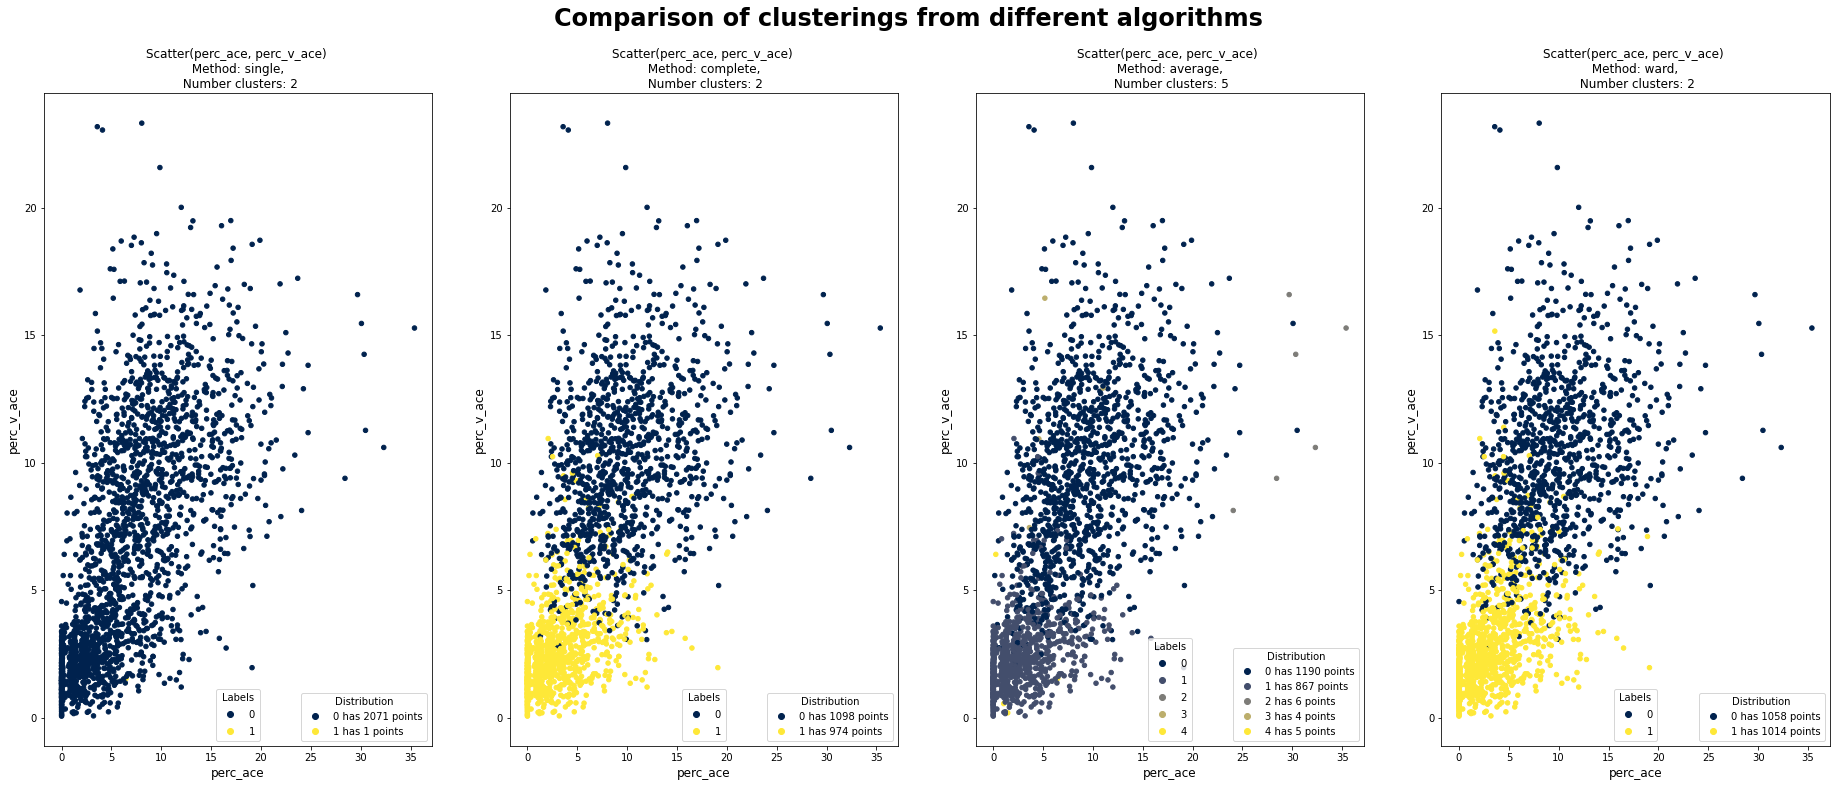

In [23]:
a, b = 'perc_ace', 'perc_v_ace'
comparison(a,b)

## Evaluation

In [24]:
metrics=pd.DataFrame() # we create a dataframe to contain the results of the evaluation
    
sep=[]
sil=[]
cal_har=[]
cophenetic_coefficients = []

for method in methods:
    sep.append(davies_bouldin_score(data, clusters_labels[method]))
    sil.append(silhouette_score(data, clusters_labels[method]))
    cal_har.append(calinski_harabasz_score(data, clusters_labels[method]))
    Z = linkage(data, method)
    cophenetic_coefficients = np.append(cophenetic_coefficients, np.corrcoef(pdist(data), cophenet(Z))[0][1])
    
#internal metric
metrics['Methods'] = methods
metrics['Davies_Bouldini'] = sep
metrics['Silhouette'] = sil
metrics['Calinski_Harabasz'] = cal_har

#esternal metric
metrics['cophenetic_corr'] = cophenetic_coefficients

#set index to methods
metrics.set_index(['Methods'], inplace=True)
metrics

,Davies_Bouldini,Silhouette,Calinski_Harabasz,cophenetic_corr
Methods,,,,
single,0.684837,0.199751,2.014265,0.264950
complete,1.429738,0.288007,934.473150,0.618364
average,1.273799,0.181079,235.069240,0.671110
ward,1.442171,0.284544,919.360115,0.631931
